<a href="https://colab.research.google.com/github/PPSolanki/DA_Lab/blob/main/Exp_7_Pratham_P_Solanki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

The following is a dataset which shows us the comparison between Saudi Arabian Riyal and the US Dollar between 2019 and 2021

In [2]:
df = pd.read_csv("/content/digital_curr.csv")
df.set_index("Unnamed: 0", inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
Unnamed: 0,,,,,,,,,
2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


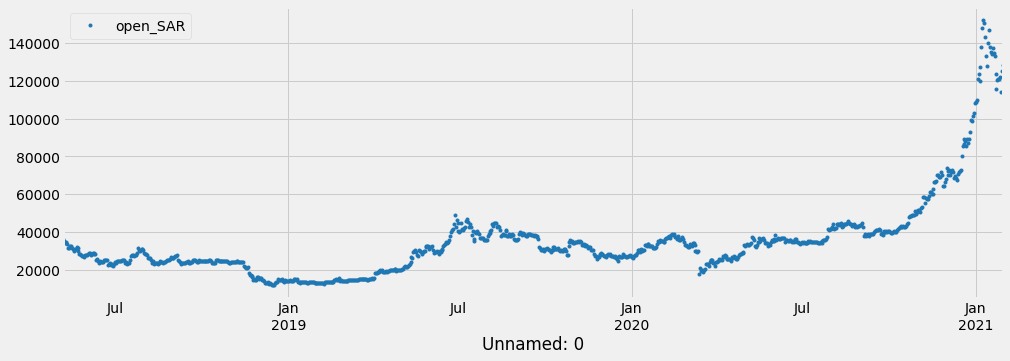

In [3]:
df.plot(y='open_SAR', figsize=(15, 5), style='.', color=color_palette[0])

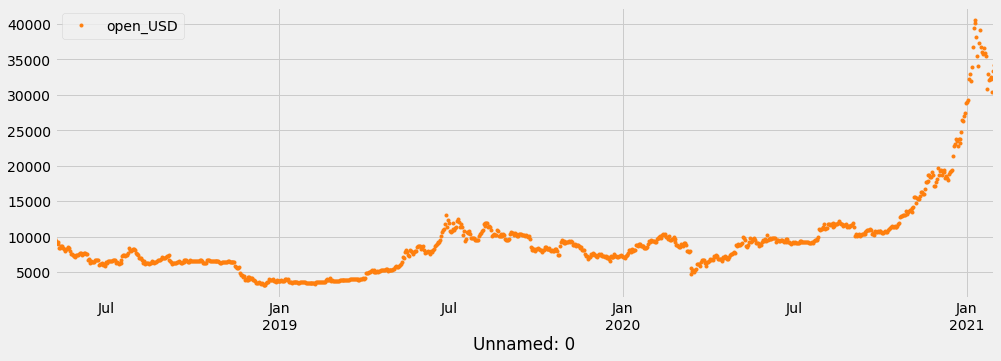

In [4]:
df.plot(y='open_USD', figsize=(15, 5), style='.', color=color_palette[1])

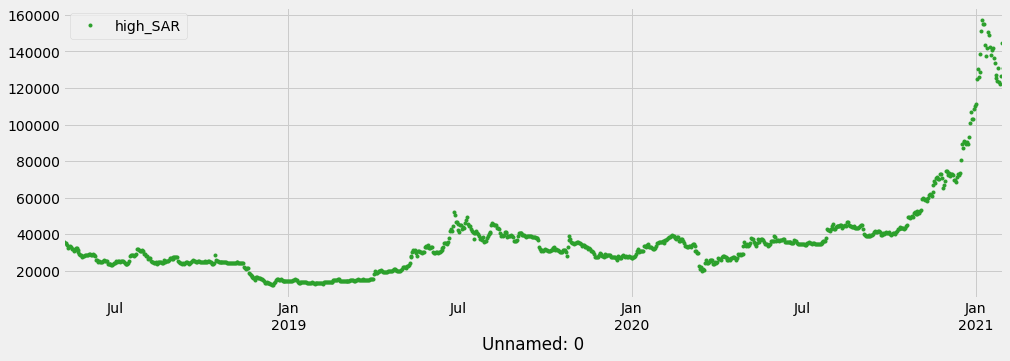

In [5]:
df.plot(y='high_SAR', figsize=(15, 5), style='.', color=color_palette[2])

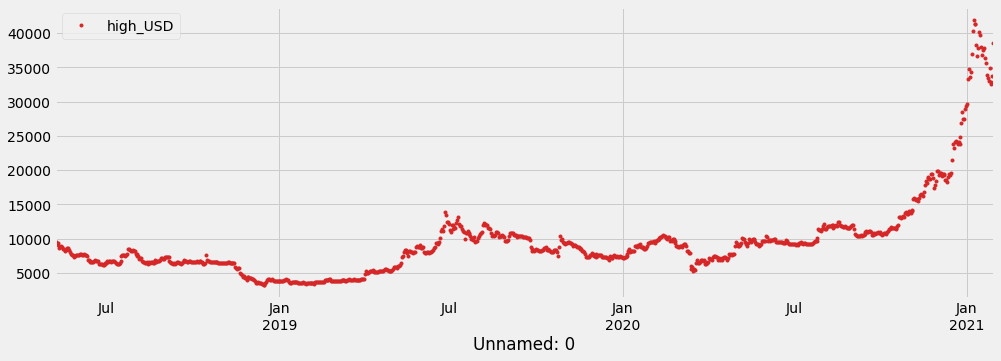

In [6]:
df.plot(y='high_USD', figsize=(15, 5), style='.', color=color_palette[3])

We can see that both the currencies have similar trends, which is to be expected. Both having sharp slope around July 2019 and a steep drop around March 2020, whichis followed by a continuous never before seen rise around January 2021

In this subsection, We observe the distribution of the values of each feature. Moreover, this subsection is intended to confirm the trends observed in the previous section

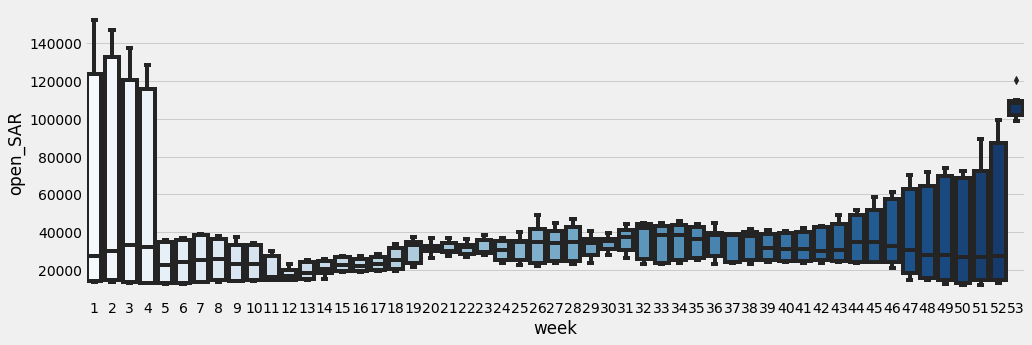

In [7]:
df['week'] = df.index.isocalendar().week
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='open_SAR', palette='Blues')

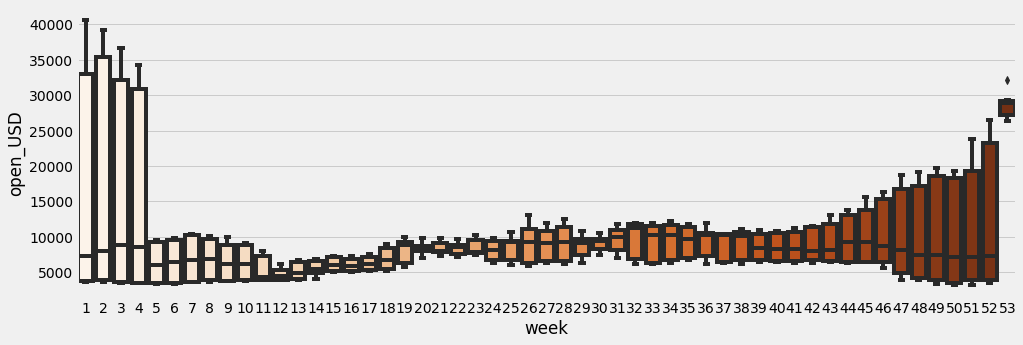

In [8]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='open_USD', palette='Oranges')

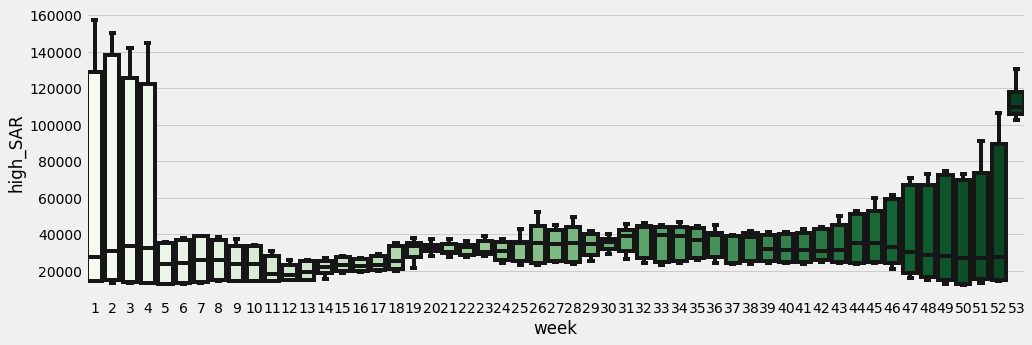

In [9]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='high_SAR', palette='Greens')

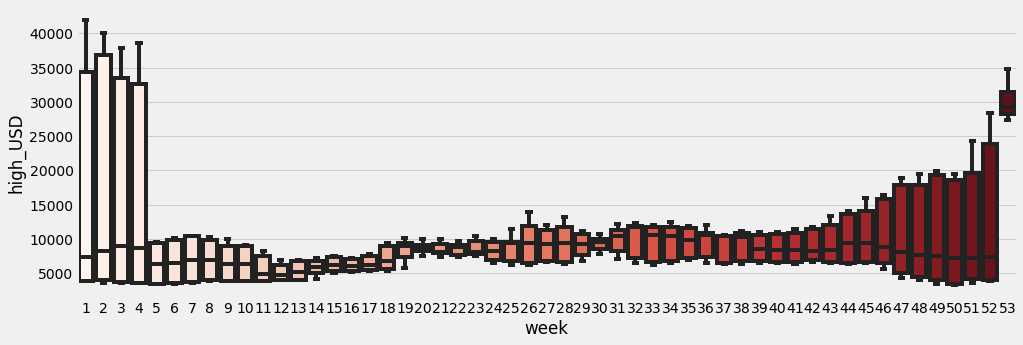

In [10]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, x='week', y='high_USD', palette='Reds')

Next we will create a model to predict the openings and highs of Riyal and USD

In [11]:
def create_features(df):
    ret = df.copy()
    ret['week'] = ret.index.isocalendar().week
    ret['month'] = ret.index.month
    return ret

In [12]:
df = create_features(df)
df.head(5)

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume,week,month
Unnamed: 0,,,,,,,,,,,
2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072,4,1
2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827,4,1
2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621,4,1
2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911,4,1
2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972,4,1


The dates selected here gives us a 80:20 split for training and testing data

In [13]:
test = df.loc[df.index < '2018-11-23']
train = df.loc[df.index >= '2018-11-23']
train.describe()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume,week,month
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,37101.838467,9892.768362,38184.023231,10181.320188,35972.334249,9591.599363,37241.790362,9930.084888,58235.003750,27.025000,6.570000
std,23708.525483,6321.599158,24862.542027,6629.304081,22427.705927,5980.083705,23915.614945,6376.817125,36972.425305,16.017571,3.659828
min,12045.197184,3211.710000,12288.185600,3276.500000,11837.237504,3156.260000,12045.234688,3211.720000,13525.000000,1.000000,1.000000
25%,25722.277792,6858.542500,26833.305664,7154.785000,25017.577632,6670.642500,25751.202752,6866.255000,33181.250000,13.000000,3.000000
50%,34069.589952,9084.255000,34635.450304,9235.135000,33294.982336,8877.715000,34134.059328,9101.445000,48177.000000,27.000000,7.000000
75%,40145.144192,10704.230000,40963.744000,10922.500000,39235.240896,10461.615000,40237.385280,10728.825000,71187.000000,41.000000,10.000000
max,152217.334784,40586.960000,157329.280000,41950.000000,145215.488000,38720.000000,152201.770624,40582.810000,402201.000000,53.000000,12.000000


In [14]:
def rectify_format(features, target, train=train, test=test):
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    X_train[features] = X_train[features].astype(np.int64)
    X_test[features] = X_test[features].astype(np.int64)
    
    return X_train, X_test, y_train, y_test

In [15]:
features = ['week', 'month']
target = 'open_USD'

In [16]:
X_train, X_test, y_train, y_test = rectify_format(features, target, train, test)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [17]:
mean_temp_reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',
                       max_depth=6,
                       learning_rate=0.5)
mean_temp_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:7603.32	validation_1-rmse:2210.2
[100]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[200]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[300]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[400]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[500]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[600]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[700]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[800]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[900]	validation_0-rmse:5360.2	validation_1-rmse:3647.21
[999]	validation_0-rmse:5360.2	validation_1-rmse:3647.21


XGBRegressor(early_stopping_rounds=500, learning_rate=0.5, max_depth=6,
             n_estimators=1000, objective='reg:squarederror')